In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from preprocessing import vocab_size
import matplotlib.pyplot as plt
from tensorflow import keras
from model_definition import *
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

### Import the Data

Load in different data splits from files

In [3]:
with open('./data/train_preprocessed_routes', 'rb') as f:
    X_train, y_train = pickle.load(f).values()
with open('./data/test_preprocessed_routes', 'rb') as f:
    X_test, y_test = pickle.load(f).values()
with open('./data/val_preprocessed_routes', 'rb') as f:
    X_val, y_val = pickle.load(f).values()

Mask Grade with CLS token

In [4]:
X_train[:, 0] = 3
X_test[:, 0] = 3
X_val[:, 0] = 3

In [5]:
np.shape(X_train)

(19076, 22)

In [6]:
X_train[0]

array([  3,   5,   7,  75,  74, 106, 128, 170, 183, 215,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

### Model Training

In [7]:
num_layers = 3
d_model = 32
dff = 512
num_heads = 9
dropout_rate = 0.15
epochs = 100
replica_batch = 56
warmup_steps = 6000


#epochs = 100
#warmup_steps = 6000

#batch_size = 128

num_classes = len(np.unique(y_train))
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train) 
class_weights=dict(zip(np.unique(y_train), class_weights))

In [8]:
multi_gpu = True #If true, distrubutes over all GPUS allocated. If false, runs on 1 gpu

In [9]:
def get_compiled_model():    
    learning_rate = CustomSchedule(d_model, warmup_steps=warmup_steps)
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.79, beta_2=0.98, epsilon=6.36e-8)
    
    model = EncoderClassifier(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=vocab_size,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        activation='relu'
    )
    
    model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=optimizer,
            metrics=['accuracy'])
    
    return model

In [10]:
def define_workers(strategy):
    replicas = strategy.num_replicas_in_sync
    batch_size = replica_batch*replicas
    return replicas, batch_size

In [11]:
def distribute_dataset(strategy):
    train_dist = strategy.experimental_distribute_dataset(train_dataset)
    val_dist = strategy.experimental_distribute_dataset(val_dataset)
    return train_dist, val_dist

In [12]:
import os
checkpoint_path = "model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path, 
            save_weights_only=True,
            monitor='val_accuracy',
            save_best_only=True,
            initial_value_threshold=0.49,
            verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir='./logs')]

In [14]:
if(multi_gpu):
    #Create a MirroredStrategy.
    strategy = tf.distribute.MirroredStrategy()
    print("Number of devices: {}".format(strategy.num_replicas_in_sync))

    #Open a strategy scope.
    with strategy.scope():
        #Everything that creates variables should be under the strategy scope.
        #In general this is only model construction & `compile()`.
        model = get_compiled_model()
        
    replicas, batch_size = define_workers(strategy)
    steps_per_epoch = np.ceil((np.shape(X_train)[0]/batch_size))
    print(steps_per_epoch, replicas, batch_size)
else:
    model = get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
171.0 2 112


In [15]:
if(multi_gpu):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat(epochs).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).repeat(epochs).batch(batch_size)
else:
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [ ]:
if(multi_gpu):
    train_dist, val_dist = distribute_dataset(strategy)
    history = model.fit(train_dist, batch_size=replica_batch, epochs=epochs, 
                        validation_data=val_dist, steps_per_epoch=steps_per_epoch, validation_steps=replicas,
                        callbacks = my_callbacks, verbose=1)
else:
    history = model.fit(train_dataset, batch_size=batch_size, epochs=epochs, \
                        validation_data=val_dataset, verbose=1, callbacks = my_callbacks)

Epoch 1/100


2023-03-28 19:24:05.276186: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 19076
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 22
        }
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
     

INFO:tensorflow:batch_all_reduce: 54 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 54 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').


2023-03-28 19:24:17.574857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-28 19:24:17.886518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-03-28 19:24:17.886578: W ./tensorflow/compiler/xla/stream_executor/stream.h:1553] attempting to perform DNN operation using StreamExecutor without DNN support


In [104]:
# Creates the base model 
new_model = get_compiled_model()

In [106]:
# The base model only gets about ~20% accuracy as it is not trained at all 
# This is to show that the base model before loading the weights is not trained
# and its accuracy is not good.
new_model.evaluate(X_test, y_test, batch_size=batch_size)

12/12 [==============================] - 0s 27ms/step - loss: 2.7325 - accuracy: 0.1355


[2.732464551925659, 0.13548387587070465]

In [107]:
# This loads the weights of the model that was saved at a certain epoch and val_accuracy
epoch = np.argmax(history.history['val_accuracy'])
val_accuracy = history.history['val_accuracy'][epoch]
epoch = epoch+1

path = f"model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
print(path)
new_model.load_weights(path)

model_weights/weights.epoch:[02]-val_acc:[0.50].hdf5


In [108]:
# After loading the weights of a previously trained model, the accuracy matches the
# best version of the model that the checkpoints were saved from
loss, acc = new_model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'loss: {loss:.4f}, accuracy: {acc:.4f}')

12/12 [==============================] - 0s 25ms/step - loss: 1.3055 - accuracy: 0.4567
loss: 1.3055, accuracy: 0.4567


In [109]:
# This is to show that the accuracy is higher than the the last epoch of the model with loaded weights.
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'loss: {loss:.4f}, accuracy: {acc:.4f}')

12/12 [==============================] - 0s 17ms/step - loss: 1.6906 - accuracy: 0.4788
loss: 1.6906, accuracy: 0.4788


### Training Plots

0.7486458420753479

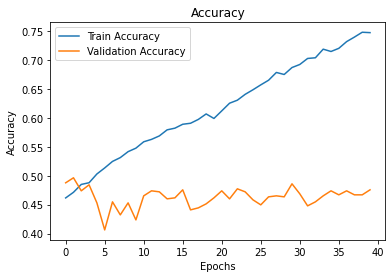

In [110]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

history.history['accuracy'][np.argmax(history.history['accuracy'])]

2.1993823051452637

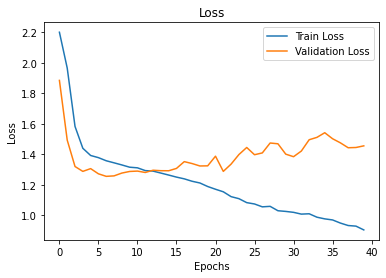

In [78]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

history.history['loss'][np.argmax(history.history['loss'])]

100.0


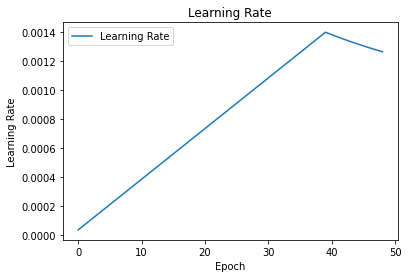

In [79]:
learning_rate = CustomSchedule(d_model)
steps_per_epoch = np.ceil((np.shape(X_train)[0]/global_batch))
print(steps_per_epoch)
lr = np.array([])
for i in range(1, np.maximum(epochs+10, 30)):
    lr = np.append(lr, learning_rate.__call__(i*steps_per_epoch))
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.plot(lr, label='Learning Rate')
plt.legend()


### Model Evaluation

In [80]:
epoch = np.argmax(history.history['val_accuracy'])
loss = history.history['loss'][epoch]
accuracy = history.history['accuracy'][epoch]
val_loss = history.history['val_loss'][epoch]
val_accuracy = history.history['val_accuracy'][epoch]
epoch += 1

print(f'best epoch: {epoch}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')

best epoch: 22, loss: 1.1545, accuracy: 0.5166, val_loss: 1.2882, val_accuracy: 0.4983


In [81]:
path = f"model_weights/weights.epoch:[{epoch:02d}]-val_acc:[{val_accuracy:.2f}].hdf5"
print(path)
test_model = get_compiled_model()
test_model.build((19072,22))
test_model.load_weights(path)

model_weights/weights.epoch:[22]-val_acc:[0.50].hdf5


In [82]:
pred = test_model.predict(X_test)

68/68 [==============================] - 1s 10ms/step


In [83]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
def un_norm_cm(norm_cm):
    np.array([
        cm[i] / np.sum(cm[i]) for i in range(len(cm))
    ])
    
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()
def top_1_accuracy(cm):
    return (cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum()) / cm.sum()
def top_2_accuracy(cm):
    return (cm.diagonal(-2).sum() + cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum() +
                 cm.diagonal(2).sum()) / cm.sum()

In [84]:
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))
print('+-1 accuracy', top_1_accuracy(cm))
print('+-2 accuracy', top_2_accuracy(cm))

accuracy 0.4612903225806452
+-1 accuracy 0.8400921658986175
+-2 accuracy 0.9617511520737327


Heatmap

<AxesSubplot:>

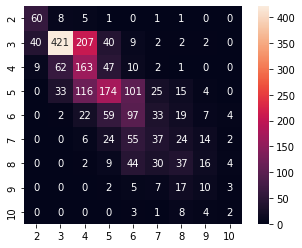

In [85]:
sns.heatmap(cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='g', square=True)

Normalized Heatmap

<AxesSubplot:>

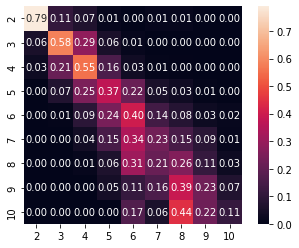

In [86]:
sns.heatmap(normalized_cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='.2f', square=True)